# Homework 2: Regression

## Task 2: Regression on Sydney Dataset

You can load the Sydney housing dataset from https://www.kaggle.com/shree1992/housedata
where you can also find a description. The goal is to predict the ‘price’ column. For this
assignment you can ignore the date. Please don’t make any kernels public on Kaggle before
the assignment ends.

2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).

2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [2]:
import warnings
warnings.filterwarnings('ignore')

## EDA and Pre-processing

In [3]:
df = pd.read_csv("data.csv", parse_dates=['date'])

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [5]:
df.drop(['country', 'street', 'date'], axis=1, inplace=True)

In [6]:
df.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
city              object
statezip          object
dtype: object

In [7]:
df.shape

(4600, 15)

Drop rows with an invalid price. In this case $0 or less.

In [8]:
df.drop(df[df.price <= 0].index, inplace=True)

In [9]:
df.shape

(4551, 15)

In [10]:
X = df.drop('price', axis=1)
y = pd.DataFrame(df['price'])

In [11]:
features = list(X.columns)
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'city',
 'statezip']

Determine the continuous and categorical features

In [12]:
categorical = [i for i,v in (X.dtypes == object).items() if v]
continuous = [i for i,v in (X.dtypes == object).items() if not v]

categorical_columns_index = [i for i,v in enumerate(features) if(v in categorical)]
continuous_columns_index = [i for i,v in enumerate(features) if(v in continuous)]

In [13]:
print("Continuous features: {}".format(continuous))
print()
print("Categorical features: {}".format(categorical))

Continuous features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

Categorical features: ['city', 'statezip']


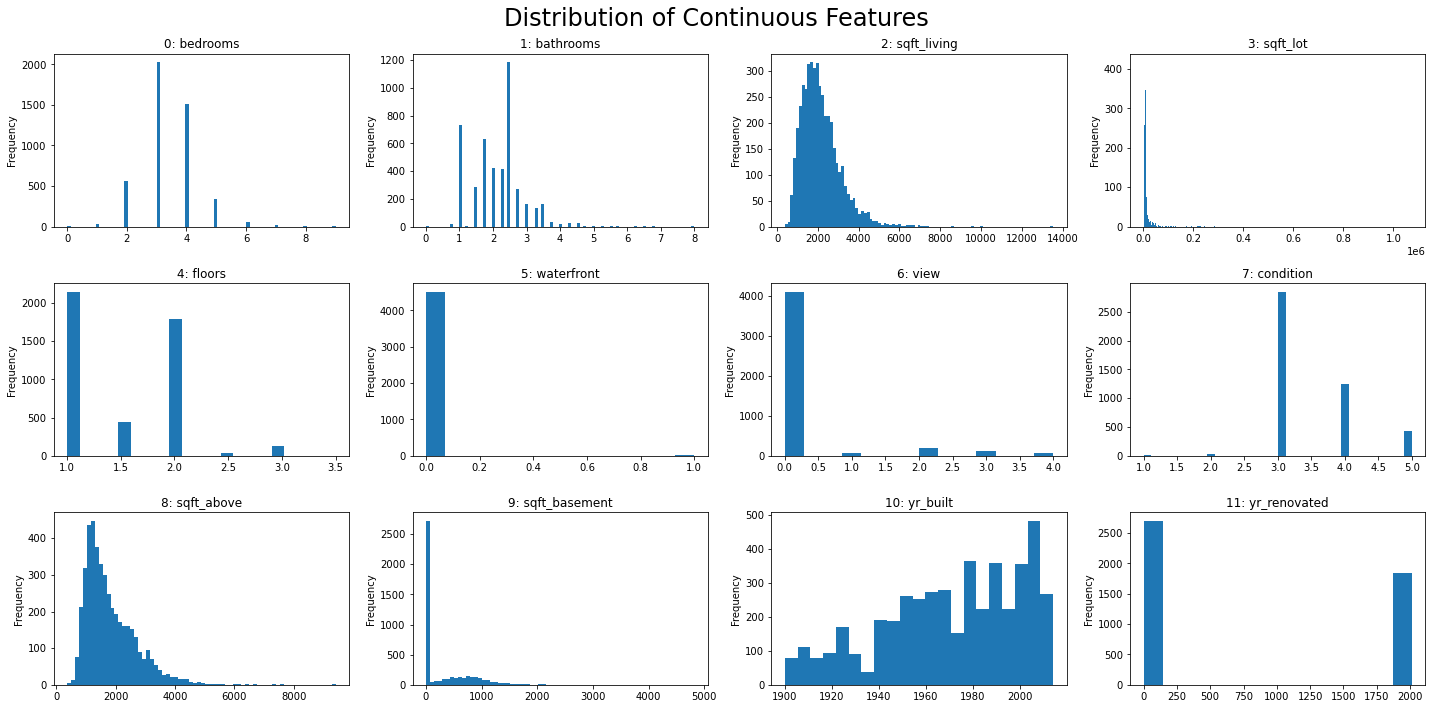

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.hist(X.iloc[:,i],bins="auto")
    ax.set_title("{}: {}".format(i, continuous[i]))
    ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Continuous Features", fontsize=24)
plt.tight_layout()
plt.show()

Observations:
- yr_renovated seems to have missing values (0)
- waterfront, view & condition show nominal distributions

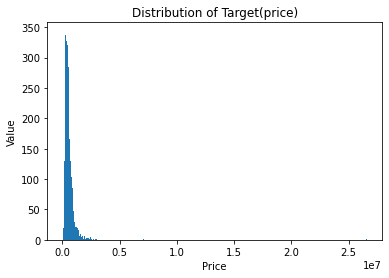

In [15]:
plt.hist(df["price"], bins="auto")
plt.xlabel("Price")
plt.ylabel("Value")
plt.title("Distribution of Target(price)")
plt.show()

Observation:
- it looks like the dependent variable price is skewed to the right (positive skew)
- log transformation can provide a uniform distribution

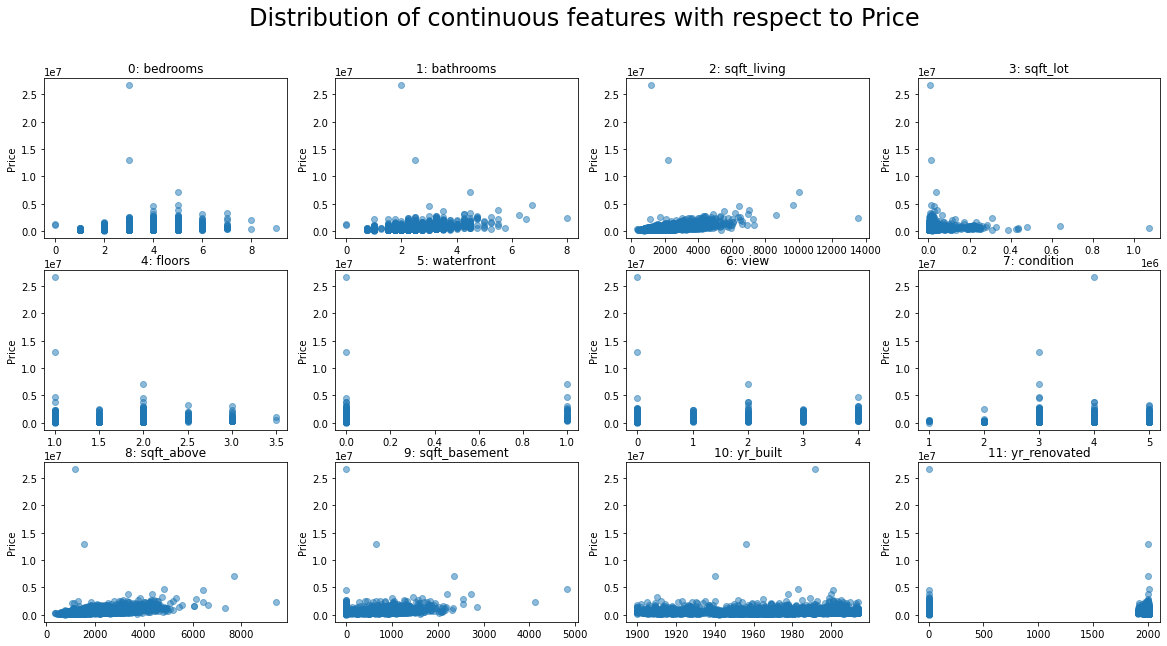

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X.iloc[:,i], y, 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, continuous[i]))
    ax.set_ylabel("Price")
    fig.suptitle("Distribution of continuous features with respect to Price", fontsize=24)
plt.show()

## Model Building

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

OnHotEncode categorical features, and impute missing continuous values:

In [68]:
# use OneHotEncoder for categorical
# update: OHE causes nan when scaling data
# preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),
#                                      (SimpleImputer(missing_values=0, strategy="median"),continuous_columns_index))

In [69]:
# use target encoder for categorical
preprocess = make_column_transformer((TargetEncoder(), categorical_columns_index),
                                     (SimpleImputer(missing_values=0, strategy="median"),continuous))

### Evaluate using Linear Regression (OLS), Ridge, Lasso and ElasticNet

In [70]:
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']

pipe1 = Pipeline([('preprocess', preprocess),
                 ('regressor', LinearRegression())])

pipe2 = Pipeline([('preprocess', preprocess),
                 ('regressor', Ridge())])

pipe3 = Pipeline([('preprocess', preprocess),
                 ('regressor', Lasso())])

pipe4 = Pipeline([('preprocess', preprocess),
                 ('regressor', ElasticNet())])

pipes = [pipe1, pipe2, pipe3, pipe4]

scores = []
for i in pipes:
    score = cross_val_score(i, X_train, y_train, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The Validation score for {} is: {}".format(model_names[i], str(scores[i])))

The Validation score for Linear Regression is: 0.4682616014592963
The Validation score for Ridge Regression is: 0.4682650007682211
The Validation score for Lasso Regression is: 0.4682620903660631
The Validation score for Elastic Net is: 0.4616627769431959


Next try scaling the data and evaluate the difference in scores

In [71]:
scaled = make_column_transformer((StandardScaler(), continuous_columns_index), remainder = 'passthrough')

model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']

pipe1 = Pipeline([('preprocess', preprocess),
                  ('scaler', scaled),
                 ('regressor', LinearRegression())])

pipe2 = Pipeline([('preprocess', preprocess),
                  ('scaler', scaled),
                 ('regressor', Ridge())])

pipe3 = Pipeline([('preprocess', preprocess),
                  ('scaler', scaled),
                 ('regressor', Lasso())])

pipe4 = Pipeline([('preprocess', preprocess),
                  ('scaler', scaled),
                 ('regressor', ElasticNet())])

pipes = [pipe1, pipe2, pipe3, pipe4]

scores = []
for i in pipes:
    score = cross_val_score(i, X_train, y_train, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The Validation score for {} is: {}".format(model_names[i], str(scores[i])))

The Validation score for Linear Regression is: 0.46826160145930285
The Validation score for Ridge Regression is: 0.4682927757471417
The Validation score for Lasso Regression is: 0.4682627368525676
The Validation score for Elastic Net is: 0.457809591397844


Scaling provides a marginal improvement on all models except for Elastic Net.

### Tune Parameters Using GridSearchCV

In [175]:
model_names = ['Ridge Regression', 'Lasso Regression', 'Elastic Net']

param_grid = [{'regressor__alpha': np.logspace(-5, 3, 15)},
              {'regressor__alpha': np.logspace(-5, 3, 15)},
              {'regressor__l1_ratio':np.logspace(-5, 1, 15)}
]

pipes = [pipe2, pipe3, pipe4]

scores = []
params = []
coef = []
columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__l1_ratio', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score']
df = pd.DataFrame(columns=columns)

for i in range(len(model_names)):
    grid = GridSearchCV(pipes[i], param_grid[i])
    grid.fit(X_train, y_train)
    
    best_score = grid.score(X_test, y_test)
    best_params = grid.best_params_
    data = pd.DataFrame(grid.cv_results_)
    data['model_name'] = model_names[i]
    c = list(grid.best_estimator_.get_params()['regressor'].coef_)
    
    scores.append(best_score)
    params.append(best_params)
    df = df.append(data)
    coef.append(c)
    
for i in range(len(model_names)):
    print("The best score for {} is: {} with the parameter value: {}".format(model_names[i], str(scores[i]), params[i]))

The best score for Ridge Regression is: 0.6843845503357282 with the parameter value: {'regressor__alpha': 268.26957952797216}
The best score for Lasso Regression is: 0.6771045902345973 with the parameter value: {'regressor__alpha': 1000.0}
The best score for Elastic Net is: 0.6749086580794479 with the parameter value: {'regressor__l1_ratio': 0.5179474679231213}


Grid Search drastically improves performance across all 3 models, as we tune the hyperparameter lapha for Ridge and Lasso, and L1 for Elastic Net.

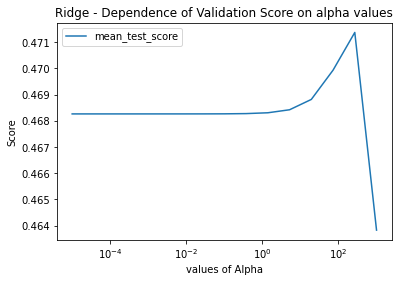

In [167]:
(df[df.model_name == 'Ridge Regression']).plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("Ridge - Dependence of Validation Score on alpha values")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

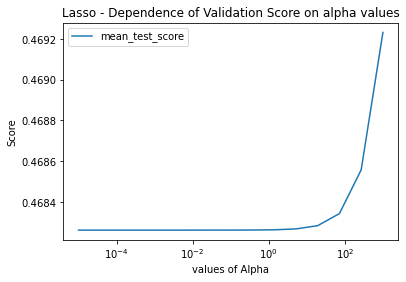

In [168]:
(df[df.model_name == 'Lasso Regression']).plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("Lasso - Dependence of Validation Score on alpha values")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

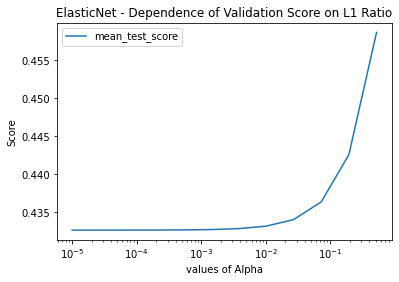

In [169]:
(df[df.model_name == 'Elastic Net']).plot('param_regressor__l1_ratio', 'mean_test_score', ax=plt.gca())
plt.xscale("log")
plt.title("ElasticNet - Dependence of Validation Score on L1 Ratio")
plt.xlabel("values of Alpha")
plt.ylabel("Score")
plt.show()

In [170]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_regressor__alpha,model_name
0,0.103546,0.010082,0.025122,0.001014,NaN,{'regressor__alpha': 1e-05},0.033608,0.295582,0.680721,0.584912,0.746485,0.468262,0.26642,14,0.00001,Ridge Regression
1,0.114702,0.008202,0.025532,0.000488,NaN,{'regressor__alpha': 3.727593720314938e-05},0.033608,0.295582,0.680721,0.584912,0.746485,0.468262,0.26642,13,0.000037,Ridge Regression
2,0.116380,0.000769,0.025515,0.000487,NaN,{'regressor__alpha': 0.00013894954943731373},0.033608,0.295582,0.680721,0.584912,0.746485,0.468262,0.26642,12,0.000139,Ridge Regression
3,0.121240,0.010963,0.026629,0.003042,NaN,{'regressor__alpha': 0.0005179474679231213},0.033608,0.295582,0.680721,0.584912,0.746485,0.468262,0.26642,11,0.000518,Ridge Regression
4,0.114773,0.005499,0.025489,0.003362,NaN,{'regressor__alpha': 0.0019306977288832496},0.033608,0.295582,0.680721,0.584912,0.746486,0.468262,0.26642,10,0.001931,Ridge Regression


### Plotting the Coefficients for each Model

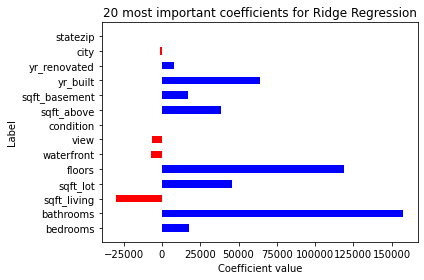

In [328]:
plt.barh(features, list(coef[0][0]), height=.5, color=plt.cm.bwr_r(np.sign(coef[0][0])))
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Ridge Regression")
plt.tight_layout()
plt.show()

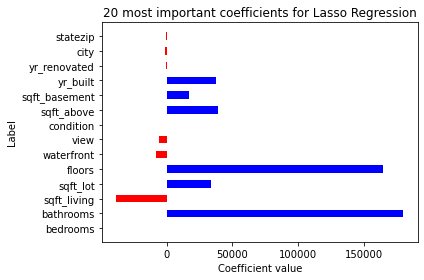

In [323]:
plt.barh(features, list(coef[1]), height=.5, color=plt.cm.bwr_r(np.sign(coef[1])))
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Lasso Regression")
plt.tight_layout()
plt.show()

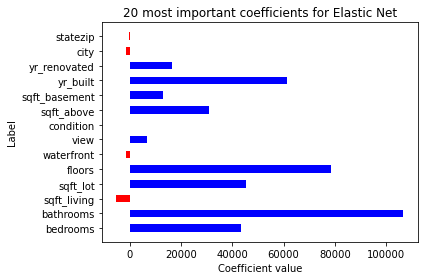

In [324]:
plt.barh(features, list(coef[2]), height=.5, color=plt.cm.bwr_r(np.sign(coef[2])))
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for Elastic Net")
plt.tight_layout()
plt.show()

Based on the charts above, it appears that all 3 models agree that bedrooms, floors and year built are the most important features. For Lasso regression, year build appears to be less important.

All 3 models agree that sqft_living is a negative coefficient. View appears to be positive for elastic net, but negative for Lasso and Ridge.